In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create the maze environment
maze = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

MAZE_SIZE = maze.shape[0]

# Start, sub-goal, and end goal positions
start_position = (1, 1)
sub_goal_position = (5, 3)
end_goal_position = (7, 8)

# Actions the agent can take: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


In [9]:
gamma = 0.8         # Discount factor
theta = 1e-5        # Convergence threshold

# Initialize value function
value_function = np.zeros(maze.shape)

# Reward matrix
reward_matrix = np.full(maze.shape, -1.0)  # Negative reward for each step
reward_matrix[sub_goal_position] = 10.0    # Reward for reaching sub-goal
reward_matrix[end_goal_position] = 500.0   # Reward for reaching end goal

def is_valid_move(x, y):
    """Check if the position is within the maze and is an open path."""
    return 0 <= x < MAZE_SIZE and 0 <= y < MAZE_SIZE and maze[x, y] == 0

def value_iteration():
    """Perform value iteration to compute the value function."""
    global value_function
    convergence_iterations = 0  # Initialize convergence iteration count
    
    while True:
        delta = 0  # Initialize maximum change in value function
        convergence_iterations += 1  # Increment iteration count
        
        for x in range(MAZE_SIZE):
            for y in range(MAZE_SIZE):
                if maze[x, y] == 0:  # Only consider open cells
                    v = value_function[x, y]  # Store current value
                    action_values = []

                    for action in actions:
                        next_x, next_y = x + action[0], y + action[1]  # Fixed indexing for next_y
                        if is_valid_move(next_x, next_y):
                            action_value = reward_matrix[next_x, next_y] + gamma * value_function[next_x, next_y]
                        else:
                            action_value = -100.0  # Penalty for hitting a wall or going out of bounds
                        action_values.append(action_value)

                    # Update value function
                    value_function[x, y] = max(action_values)
                    # Update delta for convergence check
                    delta = max(delta, abs(v - value_function[x, y]))

        # Check for convergence
        if delta < theta:
            break
            
    return convergence_iterations  # Return the number of iterations for convergence


In [10]:

def extract_policy():
    """Extract the optimal policy from the value function."""
    policy = np.full(maze.shape, -1)  # Policy initialization
    for x in range(MAZE_SIZE):
        for y in range(MAZE_SIZE):
            if maze[x, y] == 0:  # Only consider open cells
                action_values = []
                for action in actions:
                    next_x, next_y = x + action[0], y + action[1]  # Fixed indexing for next_y
                    if is_valid_move(next_x, next_y):
                        action_value = reward_matrix[next_x, next_y] + gamma * value_function[next_x, next_y]
                    else:
                        action_value = -100.0  # Penalty for hitting a wall or going out of bounds
                    action_values.append(action_value)
                
                # Find the best action based on the value function
                best_action = np.argmax(action_values)
                policy[x, y] = best_action
    return policy


In [11]:

def extract_v_path(start, goal, optimal_policy):
    """Extract the path from start to the goal using the optimal policy."""
    state = (start[0], start[1])
    path = [state[:2]]
    steps_to_sub_goal = 0  # Count steps to sub-goal
    steps_to_end_goal = 0  # Count steps to end goal
    
    while state != goal:
        action_idx = int(optimal_policy[state[0], state[1]])
        action = actions[action_idx]
        next_x = state[0] + action[0]
        next_y = state[1] + action[1]
        
        if is_valid_move(next_x, next_y):
            state = (next_x, next_y)
            path.append(state)

            # Check if the agent reached the sub-goal or end goal
            if state == sub_goal_position:
                steps_to_sub_goal = len(path)  # Count steps to sub-goal
            if state == end_goal_position:
                steps_to_end_goal = len(path)  # Count steps to end goal
        else:
            break  # Invalid move, stop the path

    return path, steps_to_sub_goal, steps_to_end_goal


In [12]:

def evaluate_agent(trials):
    """Evaluate the agent over a number of trials and track rewards and success rates."""
    success_count = 0
    total_reward = 0
    total_steps_to_sub_goal = 0
    total_steps_to_end_goal = 0
    total_convergence_speed = 0
    best_path = []
    
    # Track metrics for learning curve
    rewards_per_episode = []
    success_rates = []
    
    for episode in range(trials):
        # Reset the value function for each trial
        global value_function
        value_function = np.zeros(maze.shape)
        convergence_speed = value_iteration()
        optimal_policy = extract_policy()
        
        # Extract the path from start to end goal
        full_v_path, steps_to_sub_goal, steps_to_end_goal = extract_v_path(start_position, end_goal_position, optimal_policy)

        # Evaluate success and rewards
        if full_v_path and steps_to_end_goal > 0:
            success_count += 1
            total_reward += reward_matrix[end_goal_position]  # The reward from reaching the end goal
            total_steps_to_sub_goal += steps_to_sub_goal
            total_steps_to_end_goal += steps_to_end_goal
            total_convergence_speed += convergence_speed
            
            # Store the best path for visualization
            best_path = full_v_path
        
        # Track rewards and success rates for each episode
        rewards_per_episode.append(total_reward)
        success_rates.append(success_count / (episode + 1) * 100)  # Convert to percentage

    # Calculate metrics
    success_rate = (success_count / trials) * 100
    average_reward = total_reward / success_count if success_count > 0 else 0
    average_steps_to_sub_goal = total_steps_to_sub_goal / success_count if success_count > 0 else 0
    average_steps_to_end_goal = total_steps_to_end_goal / success_count if success_count > 0 else 0
    average_convergence_speed = total_convergence_speed / trials

    return (success_rate, average_reward, average_steps_to_sub_goal, 
            average_steps_to_end_goal, average_convergence_speed, best_path,
            rewards_per_episode, success_rates)


In [13]:
def visualize_path(path, title):
    """Visualize the optimal path taken by the agent."""
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap="gray_r")
    for (x, y) in path:
        plt.text(y, x, '•', color='orange', ha='center', va='center', fontsize=10)
    plt.text(start_position[1], start_position[0], 'S', color='green', ha='center', va='center', fontsize=20)
    plt.text(sub_goal_position[1], sub_goal_position[0], 'G', color='blue', ha='center', va='center', fontsize=20)
    plt.text(end_goal_position[1], end_goal_position[0], 'E', color='red', ha='center', va='center', fontsize=20)
    plt.title(title)
    plt.grid(True, which='both', color='black', linewidth=0.5)
    plt.xticks(np.arange(-.5, MAZE_SIZE, 1), [])
    plt.yticks(np.arange(-.5, MAZE_SIZE, 1), [])
    plt.gca().invert_yaxis()
    plt.show()

Success Rate: 100.00%
Average Reward: 500.00
Average Steps to Sub-Goal: 7.00
Average Steps to End Goal: 14.00
Average Convergence Speed: 47.00


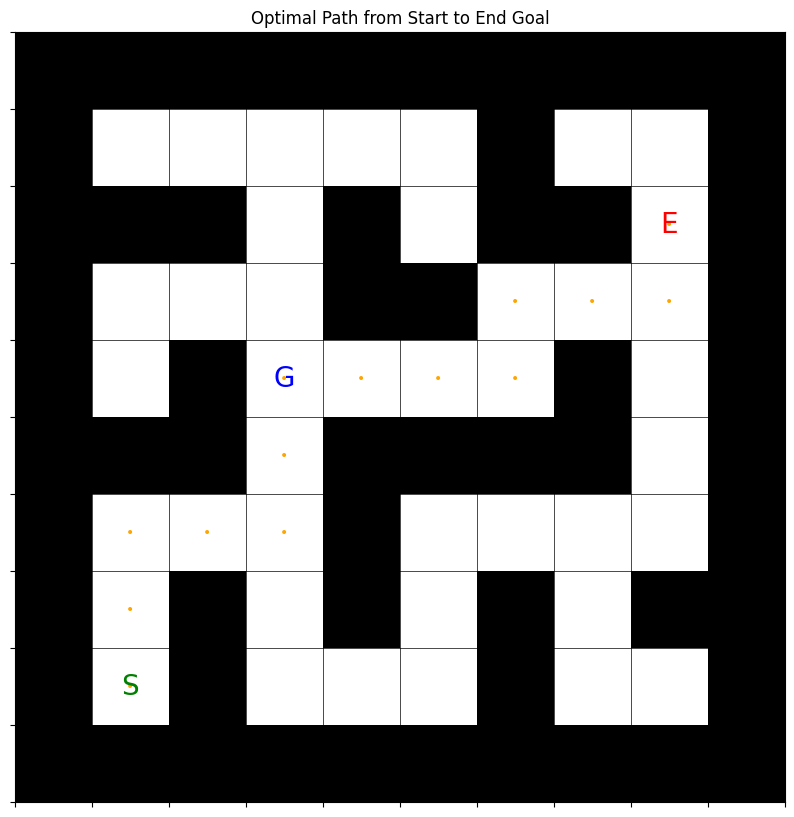

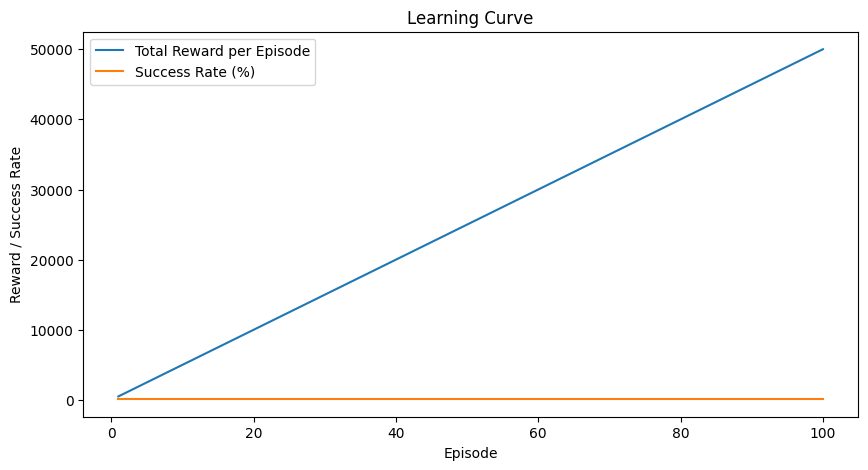

In [14]:

# Main execution
if __name__ == "__main__":
    trials = 100
    (success_rate, average_reward, avg_steps_to_sub_goal, 
     avg_steps_to_end_goal, avg_convergence_speed, best_path,
     rewards_per_episode, success_rates) = evaluate_agent(trials)

    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Reward: {average_reward:.2f}")
    print(f"Average Steps to Sub-Goal: {avg_steps_to_sub_goal:.2f}")
    print(f"Average Steps to End Goal: {avg_steps_to_end_goal:.2f}")
    print(f"Average Convergence Speed: {avg_convergence_speed:.2f}")

    # Visualize the optimal path
    visualize_path(best_path, "Optimal Path from Start to End Goal")

    # Plot learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, trials + 1), rewards_per_episode, label='Total Reward per Episode')
    plt.plot(range(1, trials + 1), success_rates, label='Success Rate (%)')
    plt.xlabel('Episode')
    plt.ylabel('Reward / Success Rate')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()
